### Проект по прогнозированию оттока клиентов в сети фитнес-центров. 

#### Основные задачи проекта. 

* Спрогнозировать вероятности оттока (на уровне следующего месяца) для каждого клиента;
* Сгрупировать и охарактеризовать типичных клиентов;
* Проанализировать основные признаки, наиболее сильно влияющие на отток клиентов;
* Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами.

#### Краткое описание. 

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Наша задача — провести анализ и подготовить план действий по удержанию клиентов. 

#### План работы.

* Откроем и изучим общую информацию о данных;
* Проведем исследовательский анализ данных;
 - Просмотрим датасет.
 - Посмотрим средние значения признаков в группах.
 - Построим столбчатые гистограммы и распределения признаков.
 - Построим матрицу корреляций.
* Построим модель прогнозирования оттока клиентов;
 - Разобьем данные на обучающую и валидационную выборки.
 - Обучим модель на train-выборке двумя способами (логистическая регрессия, случайный лес).
 - Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке.
* Сделайте кластеризацию клиентов;
 - Стандартизируем данные.
 - Построим матрицу расстояний на стандартизованной матрице признаков и нарисуем дендрограмму.
 - Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.
 - Посмотрим на средние значения признаков для кластеров.
 - Построим распределения признаков для кластеров.
 - Для каждого полученного кластера посчитаем долю оттока.
* Сформулируем выводы и сделаем базовые рекомендации по работе с клиентами.

#### Названия столбцов.

* 'gender' - пол клиента;
* 'Near_Location' - проживание или работа в районе, где находится фитнес-центр;
* 'Partner' - сотрудник компании-партнёра клуба;
* 'Promo_friends' -  факт первоначальной записи в рамках акции «приведи друга»;
* 'Phone' - наличие контактного телефона;
* 'Age' - возраст;
* 'Lifetime' - время с момента первого обращения в фитнес-центр;
* 'Contract_period' - длительность текущего действующего абонемента;
* 'Month_to_end_contract' -  срок до окончания текущего действующего абонемента;
* 'Group_visits' - факт посещения групповых занятий;
* 'Avg_class_frequency_total' - средняя частота посещений в неделю за все время с начала действия абонемента;
* 'Avg_class_frequency_current_month' - cредняя частота посещений в неделю за предыдущий месяц;
* 'Avg_additional_charges_total' - суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон;
* 'Churn' - факт оттока в текущем месяце.

### Выгружаем данные.

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

In [2]:
# предотвратим ошибки при выгрузке
import os

pth1 = '/datasets/gym_churn.csv'
if os.path.exists(pth1):
    query_1 = pd.read_csv(pth1)
else:
    print('Something is wrong')

Something is wrong


In [3]:
# выгружаем данные 
path = 'C:\\Users\\tbyni\\Рабочий стол\\Проекты ЯП_ДА\\Яндекс_12ый_проект_ДА\\'
gym_df = pd.read_csv(path + 'gym_churn.csv', sep = ',')
# gym_df.sample(5)

Выгрузка проведена успешно, начнем предобработку данных. 

### Предобработка данных. 

In [4]:
# напишем функцию чтобы просмотреть данные 
def information (a):
    display(a.head(9))
    display(a.info())
    display(a.isna().sum())
    display(a.duplicated().sum())
information(gym_df)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

None

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

0

* Отметим следующее: 
 * Название столбцов приведем в нижний регистр;
 * Для удобства округлим данные формата float до 2х цифр;
 * Столбец "Month_to_end_contract" приведем к формату int; 
 * Отсутствие пропущенных значений и дубликатов.

In [5]:
# приводим названия в нижний регистр
gym_df.columns = gym_df.columns.str.lower()

In [6]:
# округляем данные формата float
pd.options.display.float_format = '{:,.2f}'.format

In [7]:
# меняем формат данных и просмотрим, насколько корректно ли выгружаются месяцы 
gym_df['month_to_end_contract'] = gym_df['month_to_end_contract'].astype('int')
# gym_df['month_to_end_contract'].value_counts()

In [8]:
# проверяем полученные данные 
# information(gym_df)

#### Вывод.

* Для обработки была получена таблица с данными - gym_churn. (14 столбцов, 4000 строк);
* В данных отсутствуют провущенные значения и дубликаты;
* Неверный формат данных был в столбце - month_to_end_contract. (проведена предобработка, столбец приведен к формату int);
* Названия столбцов были приведены к нижнему регистру; 
* Числа формата float сократили до 2х цифр. 

### Исследовательский анализ данных (EDA).

In [9]:
# изучим средние значения и просмотрим стандартные отклонения
gym_df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,"4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00"
mean,0.51,0.85,0.49,0.31,0.90,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.30,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.00,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


* Из полученных данных выделим следующее:
 * Клиенты поделены пополам по гендерному принципу;
 * Как мы можем заметить согласно средним значениям и низкому стандартному отклонению большинство клиентов проживает около центров;
 * Почти половина клиентов пришла по партнерке, тогда акция "приведи друга" не пользуется высоким спросом;
 * Отметим наличие данных о мобильных номерах у львиной доли клиентов; 
 * Контракт заключается от 1 до 12 месяцев и как мы можем понять из высокого стандартного отклонения, разброс велик; 
 * Груповые занятия не очень популярны; 
 * Средним возраст клиента превалирует в районе 29 лет; 
 * При максимальной выручке в 552 ед., средняя выручка составяляет - практически 147 ед. 
 * Сроки окончания контракта практически равны срокам жизни контрактов; 
 * Согласно полученным данным у нас есть клиенты, как еще ни разу не посещавшие центр, так постоянные, которые занимаются уже более 2х лет; 
 * В среднем наши клиенты посещают центра 2 раза в неделю, хотя есть и яркие привержнцы которые ходят до 6 раз в неделю; 
 * Отток клиентов около 30%.

In [10]:
# Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.
gym_df.groupby('churn').agg('mean').T.sort_values(by=1, ascending=False)

churn,0,1
avg_additional_charges_total,158.45,115.08
age,29.98,26.99
contract_period,5.75,1.73
month_to_end_contract,5.28,1.66
avg_class_frequency_total,2.02,1.47
avg_class_frequency_current_month,2.03,1.04
lifetime,4.71,0.99
phone,0.90,0.90
near_location,0.87,0.77
gender,0.51,0.51


* Как можем заметим, уходящие клиенты, как правило немного младше наших постоянных клиентов, около 30 лет у постоянных клиентов и около 27 у уходящих; 
* Они реже посещают центры и контракт у них короче; 
* Меньшее кол-во из них проживает рядом с фитнес-центрами; 
* Они практически не пользуются партнерскими и промо программами; 
* Так же реже посещают групповые занятия. 

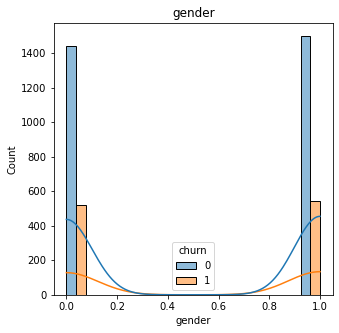

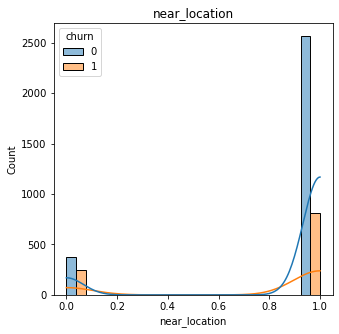

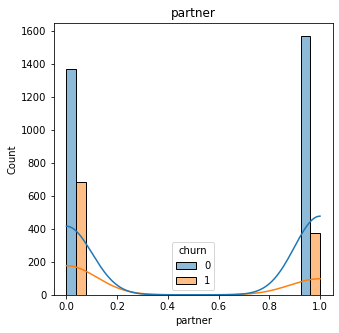

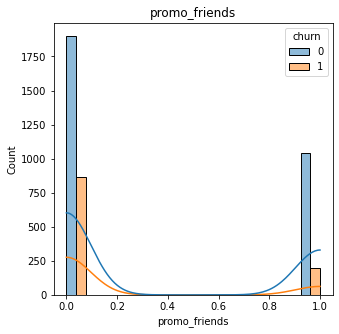

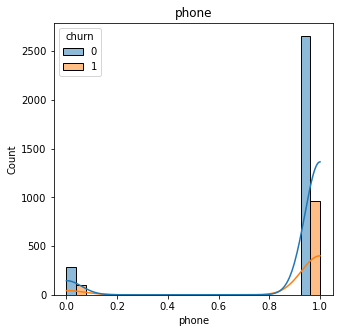

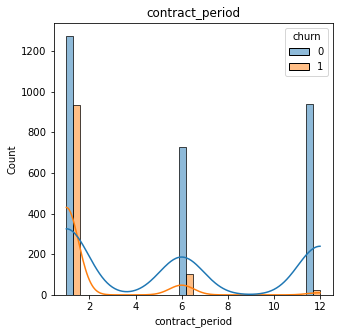

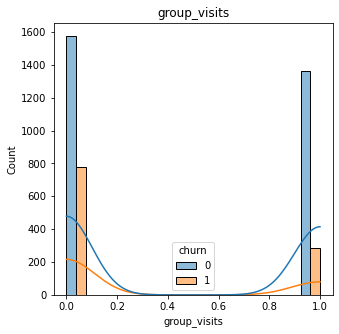

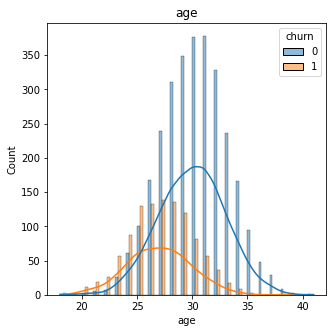

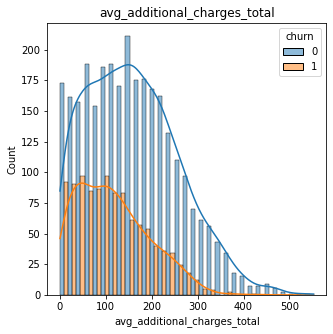

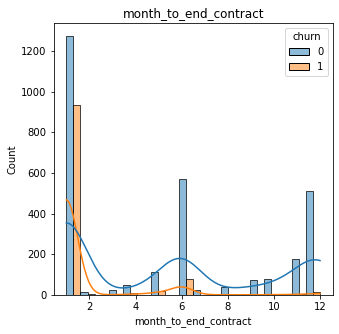

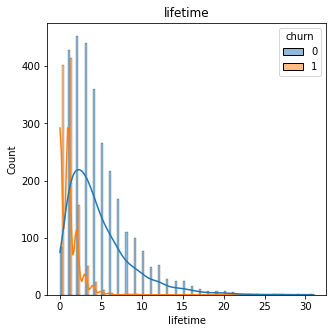

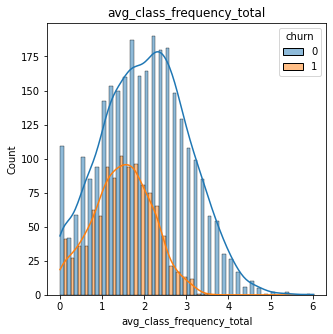

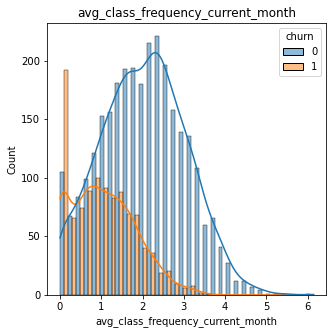

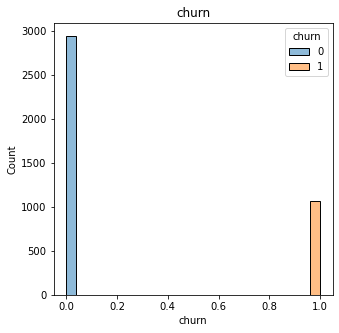

In [11]:
# строим столбчатые гистограммы и распределения признаков
for column in gym_df.columns:
    plt.figure(figsize=(5, 5))
    gym_df.groupby('churn')[column]
    sns.histplot(data=gym_df, x=gym_df[column], hue='churn', kde=True, multiple="dodge")
    plt.title(column)
    plt.show()

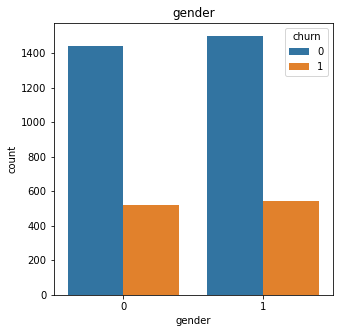

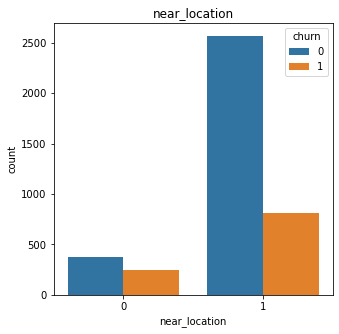

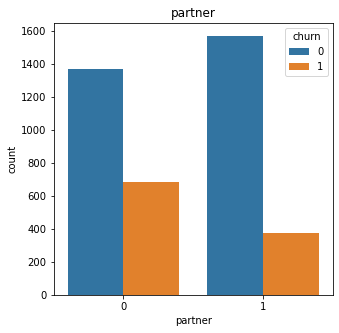

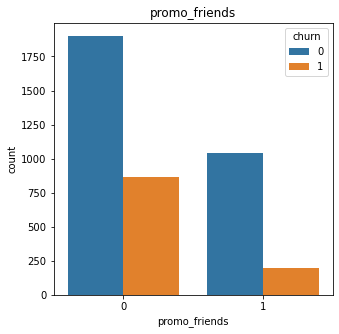

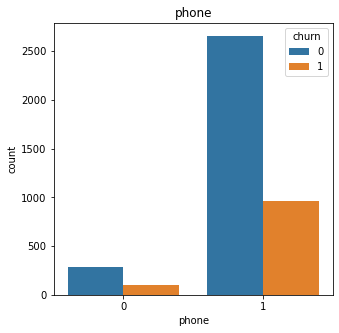

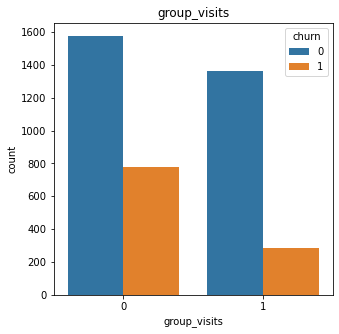

In [12]:
# смотрим распределение отток для бинарных признаков
for column in ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']:
    plt.figure(figsize=(5, 5))
    sns.countplot(x = gym_df[column], hue='churn', data=gym_df)
    plt.title(column)
    plt.show()

Text(0.5, 1.0, 'Распределение признаков для тех, кто ушел в отток')

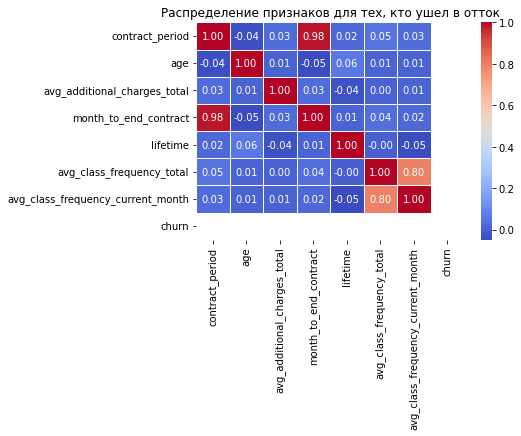

In [13]:
# строим распределение признаков для тех кто ушед в отток
df_signs = gym_df.drop(['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits'], axis=1)
df_signs_0 = df_signs[df_signs['churn'] == 0].corr()
df_signs_1 = df_signs[df_signs['churn'] == 1].corr()
sns.heatmap(df_signs_1, annot = True, fmt = '0.2f', linewidths=.5, cmap="coolwarm")
plt.title('Распределение признаков для тех, кто ушел в отток')

Text(0.5, 1.0, 'Распределение признаков для тех, кто не ушел в отток')

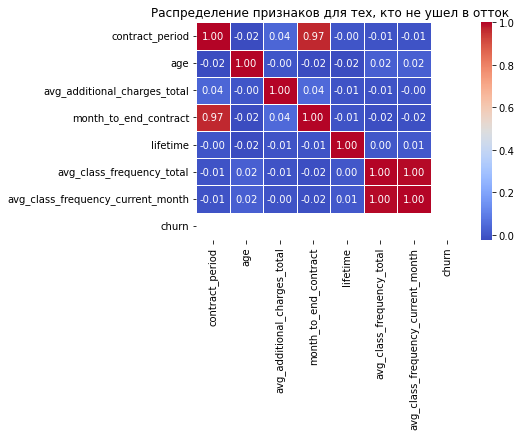

In [14]:
#посмотрим распределение и корреляцию признаков для тех, кто не ушел в отток
sns.heatmap(df_signs_0, annot = True, fmt = '0.2f', linewidths=.5, cmap="coolwarm")
plt.title('Распределение признаков для тех, кто не ушел в отток')

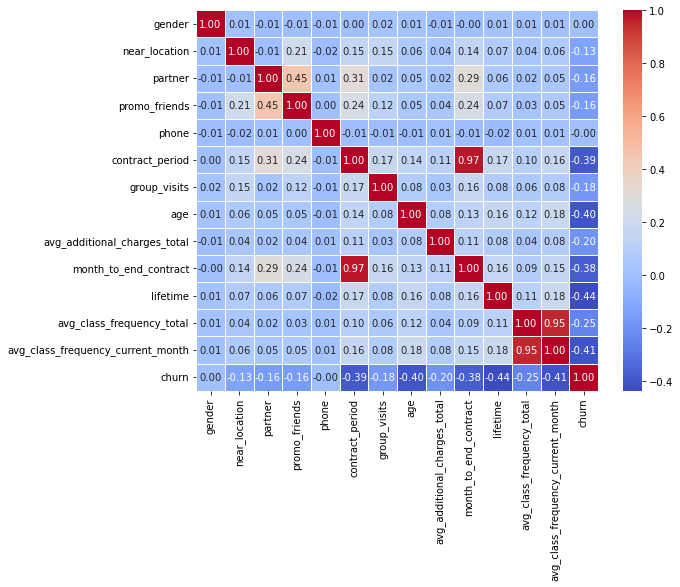

In [15]:
# матрица корреляций
corr_matrix = gym_df.corr()
plt.figure(figsize=(9, 7))
sns.heatmap(corr_matrix , annot = True, fmt = '0.2f', linewidths=.7, cmap="coolwarm")
plt.show()

Отметим следующее: 
- Наличие мультиколлинеарных признаков. (contract_period, month_to_end_contract, avg_class_frequency_total, avg_class_frequency_current_month);
- Наиболее сильное влияние на отток клиентов оказывают: длительность контракта, возраст, срок окончания договора, время с момента первого посещения и средняя частота посещений в неделю за предыдущий месяц;
- Средний возраст пользователя 28-31 и чем моложе пользователь, тем чаще он уходит в отток; 

Как мы видим большое кол-во пользователей уходит в отток после 1ых месяцев посещения центров, из чего можем предположить, что пользователи заключают пробные договора, редко посещают, а то и вовсе не приходят и в итоге уходят в отток. Можем предположить имея контактные данные мы могли бы удержать клиентов предоставя какие-то доп.предложения. 

### Модель прогнозирования оттока клиентов.

По итогу мы имеем 2 пары мультиколлинеарных признаков из которых мы попробуем 2 новых признака. 

In [16]:
# создадим новый датафрейм с выделенными признаками
df_predict = gym_df
df_predict['sign_1'] = gym_df['month_to_end_contract'] - gym_df['contract_period']
df_predict['sign_2'] = gym_df['avg_class_frequency_total'] - gym_df['avg_class_frequency_current_month']
df_predict = gym_df.drop(['month_to_end_contract', 'contract_period', 'avg_class_frequency_total', 'avg_class_frequency_current_month'], axis=1)
# df_predict.sample(10)

In [17]:
# получаем обучающую и вадидационную выборки
X = df_predict.drop('churn', axis = 1)
y = df_predict['churn']

Получены новые признаки, сформированы выборки. Далее необходимо обучить модели. 

In [18]:
# строим логистическую регресиию без стандартизации 
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    random_state=0,
                                                    stratify=y)

model = LogisticRegression(C=1.0, fit_intercept=True, random_state=0, solver='liblinear')
model.fit(X_train, y_train)

predictions = model.predict(X_test)
probabilities =  model.predict_proba(X_test)[:,1]

In [19]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, predictions)))

Accuracy: 0.91
Precision: 0.89
Recall: 0.77
F1: 0.83


Как мы можем заметить, доля правильных ответов в нашей модели более 90% - это хороший показатель. Остальные показатели, так же находятся на достаточно высоком уровне. Попробуем построить стандартизированную логистическую регресиию.

In [20]:
# строим стандартизированную логистическую регресиию
scaler = StandardScaler()
scaler.fit(X_train)

X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

standart_model = LogisticRegression(C=1.0,
                                    fit_intercept=True,
                                    random_state=0,
                                    solver='liblinear')
standart_model.fit(X_train_st, y_train)

standart_predictions = standart_model.predict(X_test_st)
standart_probabilities = standart_model.predict_proba(X_test_st)[:,1]

In [21]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, standart_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, standart_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, standart_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, standart_predictions)))

Accuracy: 0.91
Precision: 0.87
Recall: 0.79
F1: 0.83


Стандартизация позволила улучшить показатели. Обучим модель способом "случайным лесом".

In [22]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

rand_forest_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 
rand_forest_model.fit(X_train_st, y_train)

rand_forest_predictions = rand_forest_model.predict(X_test_st) 
rand_forest_probabilities = rand_forest_model.predict_proba(X_test_st)[:,1]

In [23]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rand_forest_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rand_forest_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rand_forest_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, rand_forest_predictions)))

Accuracy: 0.95
Precision: 0.95
Recall: 0.85
F1: 0.90


Обе модели показали себя достаточно хорошо, отметим, что показатели "случайного леса" все таки выше. Причем точность предсказаний в обеих моделях более 90%.  

In [24]:
gym_df

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,sign_1,sign_2
0,1,1,1,1,0,6,1,29,14.23,5,3,0.02,0.00,0,-1,0.02
1,0,1,0,0,1,12,1,31,113.20,12,7,1.92,1.91,0,0,0.01
2,0,1,1,0,1,1,0,28,129.45,1,2,1.86,1.74,0,0,0.12
3,0,1,1,1,1,12,1,33,62.67,12,2,3.21,3.36,0,0,-0.15
4,1,1,1,1,1,1,0,26,198.36,1,3,1.11,1.12,0,0,-0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.41,12,8,2.28,2.35,0,0,-0.06
3996,0,1,0,0,1,1,1,29,68.88,1,1,1.28,0.29,1,0,0.98
3997,1,1,1,1,1,12,0,28,78.25,11,2,2.79,2.83,0,-1,-0.05
3998,0,1,1,1,1,6,0,32,61.91,5,3,1.63,1.60,0,-1,0.03


### Выполним кластеризацию клиентов.

In [25]:
# стандартизируем данные 
df_cl = gym_df.drop(['churn'], axis=1)
df_gym_column = df_cl.columns
df_cl = StandardScaler().fit_transform(df_cl)
df_cl = pd.DataFrame(df_cl, columns = df_gym_column).astype('float64')
df_cl

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,sign_1,sign_2
0,0.98,0.43,1.03,1.50,-3.06,0.29,1.19,-0.06,-1.38,0.16,-0.19,-1.91,-1.68,-0.60,-0.28
1,-1.02,0.43,-0.97,-0.67,0.33,1.61,1.19,0.56,-0.35,1.83,0.87,0.05,0.14,0.33,-0.31
2,-1.02,0.43,1.03,-0.67,0.33,-0.81,-0.84,-0.36,-0.18,-0.79,-0.46,-0.02,-0.03,0.33,0.03
3,-1.02,0.43,1.03,1.50,0.33,1.61,1.19,1.17,-0.87,1.83,-0.46,1.36,1.51,0.33,-0.82
4,0.98,0.43,1.03,1.50,0.33,-0.81,-0.84,-0.98,0.53,-0.79,-0.19,-0.79,-0.61,0.33,-0.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.98,0.43,1.03,-0.67,0.33,1.61,-0.84,1.17,-1.50,1.83,1.14,0.42,0.55,0.33,-0.55
3996,-1.02,0.43,-0.97,-0.67,0.33,-0.81,1.19,-0.06,-0.81,-0.79,-0.73,-0.62,-1.40,0.33,2.71
3997,0.98,0.43,1.03,1.50,0.33,1.61,-0.84,-0.36,-0.71,1.59,-0.46,0.93,1.01,-0.60,-0.49
3998,-1.02,0.43,1.03,1.50,0.33,0.29,-0.84,0.86,-0.88,0.16,-0.19,-0.26,-0.16,-0.60,-0.24


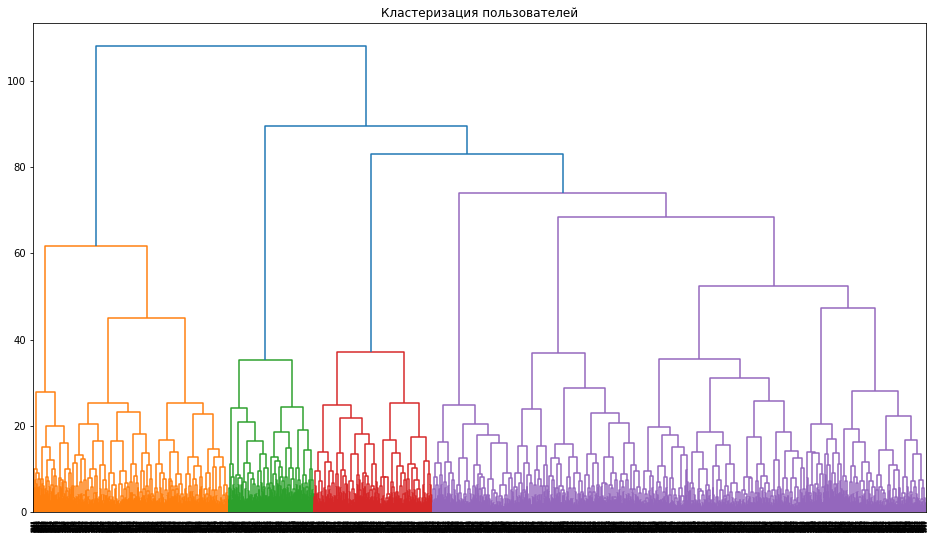

In [26]:
# строим матрицу расстояний, на стандартизованной матрице признаков и рисуем дендрограмму
link = linkage(df_cl, method = 'ward')
plt.figure(figsize=(16, 9))  
dendrogram(link, orientation = 'top')
plt.title('Кластеризация пользователей')
plt.show()

Можем выделить 4-5 кластеров. 

In [27]:
# обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов
km = KMeans(n_clusters = 5, random_state = 42)
labels = km.fit_predict(df_cl)
gym_df['cluster'] = labels

In [28]:
# посмотрим на средние значения признаков для кластеров.
gym_df.groupby('cluster').mean().T

cluster,0,1,2,3,4
gender,0.54,0.49,0.49,0.50,0.52
near_location,0.98,0.00,1.00,0.93,0.95
partner,0.33,0.46,0.36,0.71,0.77
promo_friends,0.24,0.08,0.23,0.40,0.58
phone,0.91,0.91,0.90,0.94,0.89
contract_period,2.36,2.10,1.80,11.31,10.62
group_visits,0.45,0.21,0.34,0.60,0.53
age,30.05,28.49,28.01,29.99,29.88
avg_additional_charges_total,158.21,134.56,127.82,157.85,162.16
month_to_end_contract,2.29,2.03,1.76,7.05,10.21


In [29]:
# просмотрим распределение кластеризации 
gym_df.cluster.value_counts()

2    1194
0    1065
4    1004
1     536
3     201
Name: cluster, dtype: int64

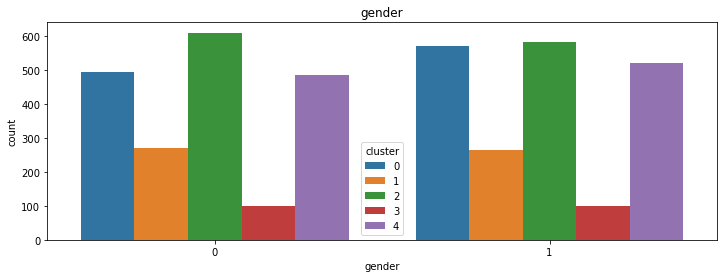

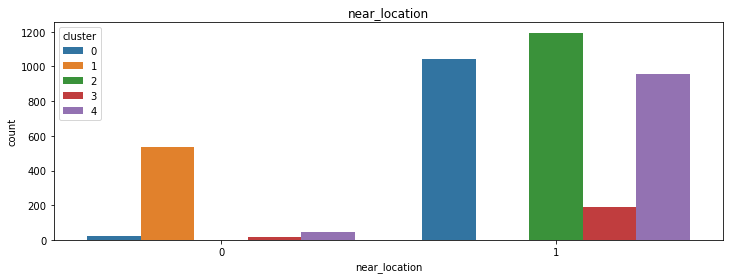

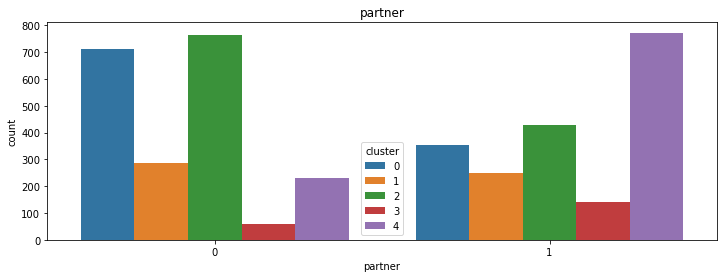

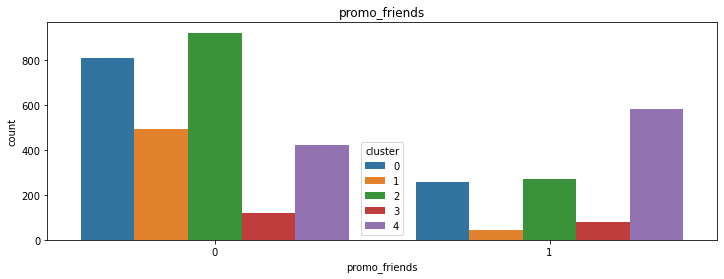

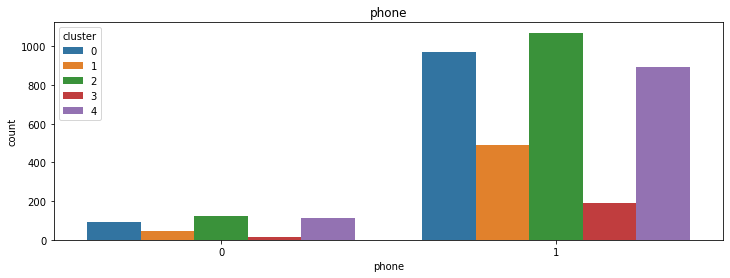

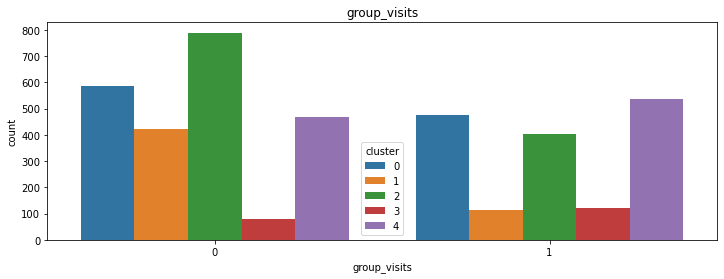

In [30]:
# распределение признаков для кластеров
categorical_columns = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']
for column in categorical_columns:
    plt.figure(figsize=(12, 4))
    sns.countplot(x=gym_df[column], hue="cluster", data=gym_df)
    plt.title(column)
    plt.show()

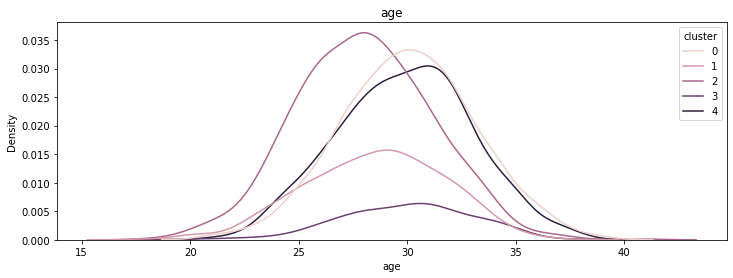

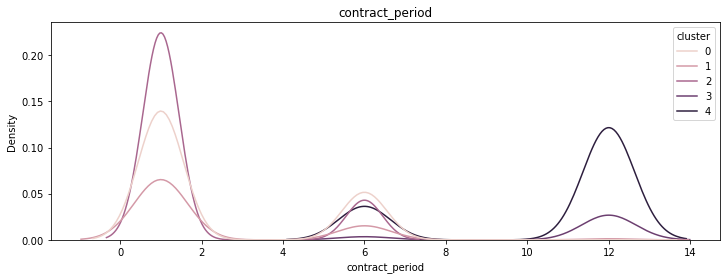

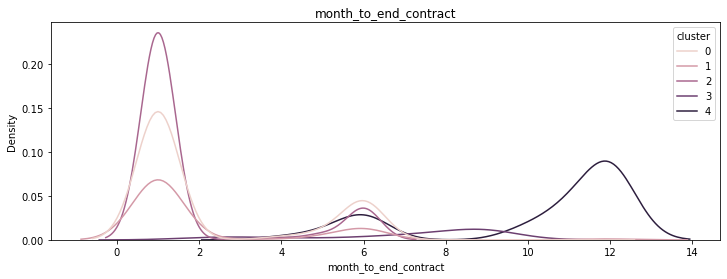

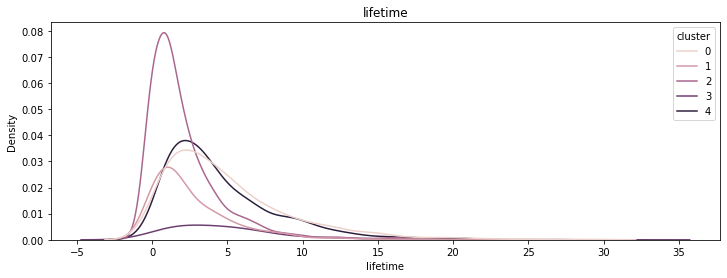

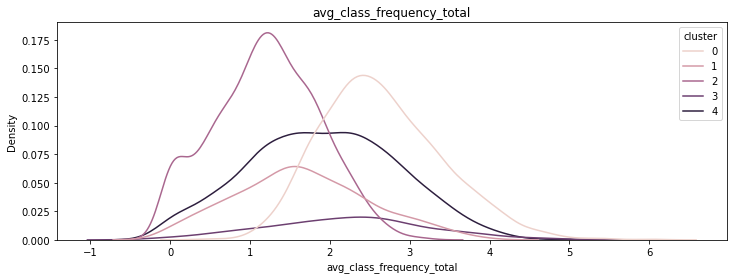

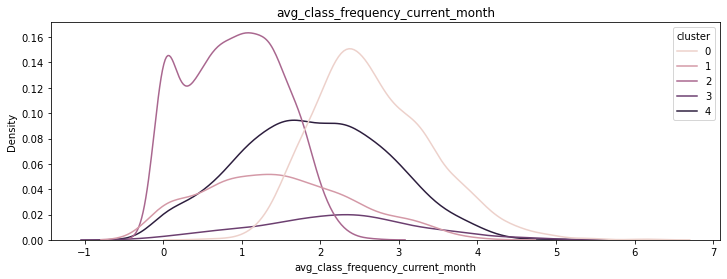

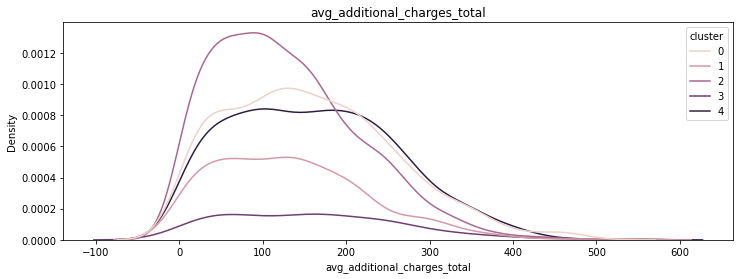

In [31]:
non_categorical_columns = ['age', 'contract_period', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month', 'avg_additional_charges_total']
for column in non_categorical_columns:
    plt.figure(figsize=(12, 4))
    sns.kdeplot(x=gym_df[column], hue="cluster", data=gym_df)
    plt.title(column)
    plt.show()

- Отметим, что получено по итогу:
 - Наиболее многочисленный кластер - 2, далее примерно поровну делятся 0 и 4 кластеры;
 - Самый высокий уровень оттока в 1 и 2 кластерах, самый низкий уровень в 3 и 4;
 - Просматривая наиболее успешные группы можем заметить, что подтверждаются наши наблюдения - клиенту в среднем 29 лет, клиент живет рядом с центром, контракт более 6 месяцев, клиенты часто приходят по партнерской программе.

### Выводы.

- Сформирован наш "лучший" клиент:
 - Живет рядом с центром;
 - Учавствует в партнерской программе; 
 - Средняя продолжительность договора более 6 месяцев;
 - Клиент в среднем около 29-30 лет; 
 - Клиенты посещают центры более 2х раз в неделю.
 
-------------------------------

- Поняли, что способствует уходу в отток:
 - Клиент проживает достаточно далеко от центра;
 - Не пользуются партнерской программой; 
 - Практически не посещают груповые занятия;
 - Посещают тренировки реже 2х раз в неделю.

---------------------------------

- На мой взгляд основная наша задача получить, как можно пользователей с контрактом более 6 месяцев, посещающих групповые занятия. Мы выделили 4-5 основных кластеров среди которых выделяются 2 кластера приносящих наибольшую прибыль и наиболее схожие.
- В данном случае чтобы получить желаемый результат мы можем предложить завести карту "привилегий", которая будет предусматривать каждый месяц новое промо с накоплением, к примеру в феврале и марте несколько бесплатных занятий с тренером, либо групповых занятий, на выбор. Так же к примеру можно приурочить промо раздачу карт например к московскому марафону.